# Develop Time Series Forecasting Models - colab version

Setup & Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error
from arch import arch_model
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Load your processed data (upload to Colab first or access from Drive)
df = pd.read_csv('/content/drive/MyDrive/processed_data.csv',
                 parse_dates=['Date'],
                 index_col='Date')

Mounted at /content/drive


In [ ]:
series = df['Close_TSLA'].sort_index()
series = series.asfreq('B').ffill()
# Train/test split
train = series.loc[:'2023-12-31'].copy()
test  = series.loc['2024-01-01':].copy()
print("Train rows:", len(train), "Test rows:", len(test))

Train rows: 2187 Test rows: 413


**Part A: ARIMA workflow**

In [ ]:
# Use auto_arima to get order
arima_auto = auto_arima(train, seasonal=False, stepwise=True, error_action='ignore', suppress_warnings=True, max_p=5, max_q=5)

In [ ]:
# Fit statsmodels ARIMA with the selected order
order = arima_auto.order
arima_mod = ARIMA(train, order=order)
arima_res = arima_mod.fit()
print(arima_res.summary())

                               SARIMAX Results                                
Dep. Variable:             Close_TSLA   No. Observations:                 2187
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -7060.141
Date:                Tue, 12 Aug 2025   AIC                          14128.283
Time:                        05:47:57   BIC                          14151.042
Sample:                    08-13-2015   HQIC                         14136.602
                         - 12-29-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9265      0.030    -30.601      0.000      -0.986      -0.867
ma.L1          0.8518      0.031     27.279      0.000       0.791       0.913
ma.L2         -0.0437      0.014     -3.026      0.0

In [ ]:
# Forecast on test period with conf intervals
n_test = len(test)
arima_pred_res = arima_res.get_forecast(steps=n_test)
arima_pred = arima_pred_res.predicted_mean
arima_ci = arima_pred_res.conf_int(alpha=0.05)  # 95% CI
arima_pred.index = test.index
arima_ci.index = test.index

In [ ]:
# Fit GARCH on residuals
do_garch = True
if do_garch:
    try:
        resid = arima_res.resid.dropna()
        garch = arch_model(resid, mean='Zero', vol='Garch', p=1, q=1)
        garch_res = garch.fit(disp='off')
        print(garch_res.summary())
    except Exception as e:
        print("GARCH failed:", e)

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4553.55
Distribution:                  Normal   AIC:                           9113.10
Method:            Maximum Likelihood   BIC:                           9130.17
                                        No. Observations:                 2187
Date:                Tue, Aug 12 2025   Df Residuals:                     2187
Time:                        05:48:09   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      5.5387e-03  2.446e-03      2.264  2.356e-02 [7.

In [ ]:
def mape(y, yhat):
    return np.mean(np.abs((y - yhat) / y)) * 100

In [ ]:
arima_mae = mean_absolute_error(test, arima_pred)
arima_rmse = np.sqrt(mean_squared_error(test, arima_pred))
arima_mape = mape(test.values, arima_pred.values)
print("ARIMA MAE: {:.4f}, RMSE: {:.4f}, MAPE: {:.3f}%".format(arima_mae, arima_rmse, arima_mape))

ARIMA MAE: 64.3714, RMSE: 78.2816, MAPE: 25.093%


**Part B: LSTM with Scaling**

In [ ]:
# Fix seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
# Scale the data (fit only on training set)
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train.values.reshape(-1, 1))
test_scaled = scaler.transform(test.values.reshape(-1, 1))


In [ ]:
# Function to create sequences
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LEN = 60  # number of time steps for LSTM input

X_train, y_train = create_sequences(train_scaled, SEQ_LEN)
X_test, y_test = create_sequences(test_scaled, SEQ_LEN)

In [ ]:
# Reshape for LSTM [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
# Build LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(SEQ_LEN, 1), activation='tanh'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
# Train model
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

Epoch 1/30
60/60 [==============================] - 5s 40ms/step - loss: 0.0116 - val_loss: 0.0022
Epoch 2/30
60/60 [==============================] - 3s 45ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 3/30
60/60 [==============================] - 3s 44ms/step - loss: 8.9841e-04 - val_loss: 0.0015
Epoch 4/30
60/60 [==============================] - 2s 31ms/step - loss: 8.3697e-04 - val_loss: 0.0013
Epoch 5/30
60/60 [==============================] - 2s 31ms/step - loss: 8.0582e-04 - val_loss: 0.0013
Epoch 6/30
60/60 [==============================] - 2s 31ms/step - loss: 7.4025e-04 - val_loss: 0.0012
Epoch 7/30
60/60 [==============================] - 2s 30ms/step - loss: 6.9112e-04 - val_loss: 0.0011
Epoch 8/30
60/60 [==============================] - 2s 31ms/step - loss: 6.3120e-04 - val_loss: 9.1268e-04
Epoch 9/30
60/60 [==============================] - 3s 49ms/step - loss: 6.2866e-04 - val_loss: 0.0011
Epoch 10/30
60/60 [==============================] - 2s 40ms/step - loss: 6.0

In [ ]:
# Make predictions (scaled)
lstm_pred_scaled = model.predict(X_test)

12/12 [==============================] - 1s 10ms/step


In [ ]:
# Inverse transform to original scale
lstm_pred = scaler.inverse_transform(lstm_pred_scaled)
y_test_rescaled = scaler.inverse_transform(y_test)

LSTM MAE: 11.3319, RMSE: 15.1031, MAPE: 4.205%


**Compare ARIMA and LSTM**

 Evaluate

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

lstm_mae = mean_absolute_error(y_test_rescaled, lstm_pred)
lstm_rmse = np.sqrt(mean_squared_error(y_test_rescaled, lstm_pred))
lstm_mape = np.mean(np.abs((y_test_rescaled - lstm_pred) / y_test_rescaled)) * 100

arima_mae = mean_absolute_error(test, arima_pred)
arima_rmse = np.sqrt(mean_squared_error(test, arima_pred))
arima_mape = np.mean(np.abs((test - arima_pred) / test)) * 100

print("LSTM MAE: {:.4f}, RMSE: {:.4f}, MAPE: {:.3f}%".format(lstm_mae, lstm_rmse, lstm_mape))
print("ARIMA MAE: {:.4f}, RMSE: {:.4f}, MAPE: {:.3f}%".format(arima_mae, arima_rmse, arima_mape))

 Align predictions with test dates

In [ ]:
# ARIMA forecast (already computed in Part A)
arima_forecast = arima_res.get_forecast(steps=len(test))
arima_pred = arima_forecast.predicted_mean
arima_ci = arima_forecast.conf_int()

# LSTM forecast alignment
# Since LSTM uses sequences, it starts predicting after SEQ_LEN steps in test set
lstm_pred_series = pd.Series(
    lstm_pred.flatten(),
    index=test.index[SEQ_LEN:]
)

Results Table

In [ ]:
results = pd.DataFrame({
    'Model': ['ARIMA', 'LSTM'],
    'MAE': [arima_mae, lstm_mae],
    'RMSE': [arima_rmse, lstm_rmse],
    'MAPE(%)': [arima_mape, lstm_mape]
})
print(results)

Plot

   Model        MAE       RMSE    MAPE(%)
0  ARIMA  64.371380  78.281635  25.093194
1   LSTM  11.331904  15.103096   4.204777


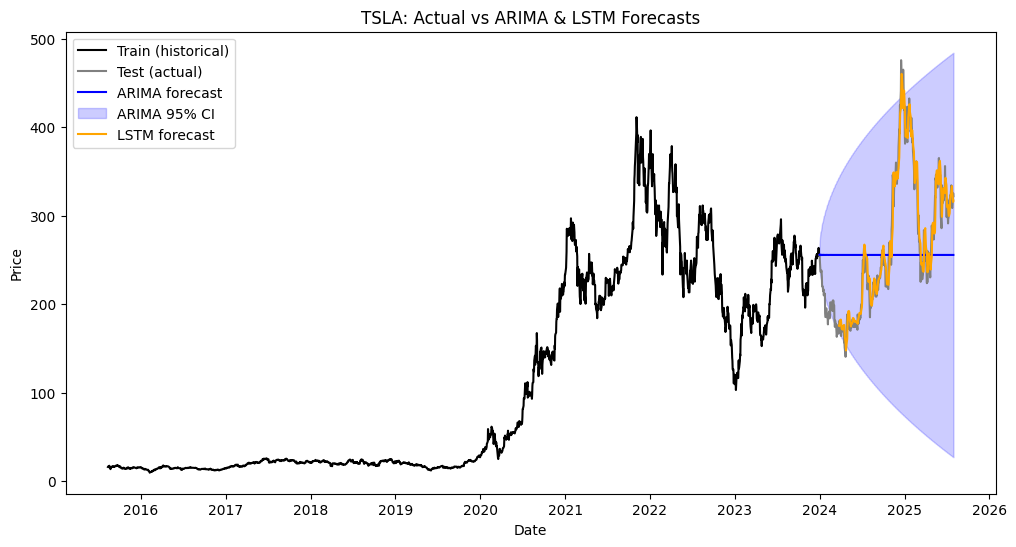

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Train (historical)', color='black')
plt.plot(test.index, test, label='Test (actual)', color='gray')

# ARIMA plot
plt.plot(arima_pred.index, arima_pred, label='ARIMA forecast', color='blue')
plt.fill_between(arima_ci.index,
                 arima_ci.iloc[:, 0],
                 arima_ci.iloc[:, 1], color='blue', alpha=0.2, label='ARIMA 95% CI')

# LSTM plot
plt.plot(lstm_pred_series.index, lstm_pred_series, label='LSTM forecast', color='orange')

plt.title('TSLA: Actual vs ARIMA & LSTM Forecasts')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

Save the LSTM model

In [ ]:
model.save("lstm_model.h5")

# Save the scaler
import joblib
joblib.dump(scaler, "scaler.save")

# Optional: save important variables
import pickle
with open("lstm_vars.pkl", "wb") as f:
    pickle.dump({"SEQ_LEN": SEQ_LEN, "train": train, "test": test}, f)


In [ ]:
model.save("lstm_model.keras")